In [26]:
%%bash
catalyst ingest-exchange -x bitfinex -i btc_usd
catalyst ingest-exchange -x bitfinex -i iot_usd

Ingesting exchange bundle bitfinex...
Ingesting daily price data on bitfinex
Ingesting exchange bundle bitfinex...
Ingesting daily price data on bitfinex


In [27]:
# Register the catalyst magic
%load_ext catalyst

The catalyst extension is already loaded. To reload it, use:
  %reload_ext catalyst


In [35]:
# Setup matplotlib to display graphs inline in this Notebook
%matplotlib inline

In [36]:
from catalyst.finance.slippage import VolumeShareSlippage

from catalyst.api import (
    order_target_value,
    symbol,
    record,
    cancel_order,
    get_open_orders,
)
import pandas as pd

def initialize(context):
    context.ASSET_NAME = 'iot_usd'
    context.TARGET_HODL_RATIO = 0.8
    context.RESERVE_RATIO = 1.0 - context.TARGET_HODL_RATIO

    # For all trading pairs in the poloniex bundle, the default denomination
    # currently supported by Catalyst is 1/1000th of a full coin. Use this
    # constant to scale the price of up to that of a full coin if desired.
    context.TICK_SIZE = 1000.0

    context.is_buying = True
    context.asset = symbol(context.ASSET_NAME)

    context.i = 0
    
def handle_data(context, data):
    context.i += 1

    starting_cash = context.portfolio.starting_cash
    target_hodl_value = context.TARGET_HODL_RATIO * starting_cash
    reserve_value = context.RESERVE_RATIO * starting_cash

    # Cancel any outstanding orders
    orders = get_open_orders(context.asset) or []
    for order in orders:
        cancel_order(order)

    # Stop buying after passing the reserve threshold
    cash = context.portfolio.cash
    if cash <= reserve_value:
        context.is_buying = False

    # Retrieve current asset price from pricing data
    price = data.current(context.asset, 'price')

    # Check if still buying and could (approximately) afford another purchase
    if context.is_buying and cash > price:
        # Place order to make position in asset equal to target_hodl_value
        order_target_value(
            context.asset,
            target_hodl_value,
            limit_price=price*1.1,
        )

    record(
        price=price,
        volume=data.current(context.asset, 'volume'),
        cash=cash,
        starting_cash=context.portfolio.starting_cash,
        leverage=context.account.leverage,
    )

def analyze(context=None, results=None):
    import matplotlib.pyplot as plt

    # Plot the portfolio and asset data.
    ax1 = plt.subplot(611)
    results[['portfolio_value']].plot(ax=ax1)
    ax1.set_ylabel('Portfolio Value (USD)')

    ax2 = plt.subplot(612, sharex=ax1)
    ax2.set_ylabel('{asset} (USD)'.format(asset=context.ASSET_NAME))
    (context.TICK_SIZE * results[['price']]).plot(ax=ax2)

    trans = results.ix[[t != [] for t in results.transactions]]
    buys = trans.ix[
        [t[0]['amount'] > 0 for t in trans.transactions]
    ]
    ax2.plot(
        buys.index,
        context.TICK_SIZE * results.price[buys.index],
        '^',
        markersize=10,
        color='g',
    )

    ax3 = plt.subplot(613, sharex=ax1)
    results[['leverage', 'alpha', 'beta']].plot(ax=ax3)
    ax3.set_ylabel('Leverage ')

    ax4 = plt.subplot(614, sharex=ax1)
    results[['starting_cash', 'cash']].plot(ax=ax4)
    ax4.set_ylabel('Cash (USD)')

    results[[
        'treasury',
        'algorithm',
        'benchmark',
    ]] = results[[
        'treasury_period_return',
        'algorithm_period_return',
        'benchmark_period_return',
    ]]

    ax5 = plt.subplot(615, sharex=ax1)
    results[[
        'treasury',
        'algorithm',
        'benchmark',
    ]].plot(ax=ax5)
    ax5.set_ylabel('Percent Change')

    ax6 = plt.subplot(616, sharex=ax1)
    results[['volume']].plot(ax=ax6)
    ax6.set_ylabel('Volume (mCoins/5min)')

    plt.legend(loc=3)

    # Show the plot.
    plt.gcf().set_size_inches(18, 8)

    plt.show()

[2018-02-02 15:57:19.428928] WARNING: run_algo: Catalyst is currently in ALPHA. It is going through rapid development and it is subject to errors. Please use carefully. We encourage you to report any issue on GitHub: https://github.com/enigmampc/catalyst/issues
[2018-02-02 15:57:22.435313] INFO: run_algo: running algo in backtest mode
[2018-02-02 15:57:22.549923] WARNING: Loader: Refusing to download new treasury data because a download succeeded at 2018-02-02 14:34:01.210187+00:00.
[2018-02-02 15:57:22.552905] INFO: exchange_algorithm: initialized trading algorithm in backtest mode
[2018-02-02 15:57:23.901718] INFO: Performance: Simulated 123 trading days out of 123.
[2018-02-02 15:57:23.902529] INFO: Performance: first open: 2017-10-01 00:00:00+00:00
[2018-02-02 15:57:23.903644] INFO: Performance: last close: 2018-01-31 23:59:00+00:00


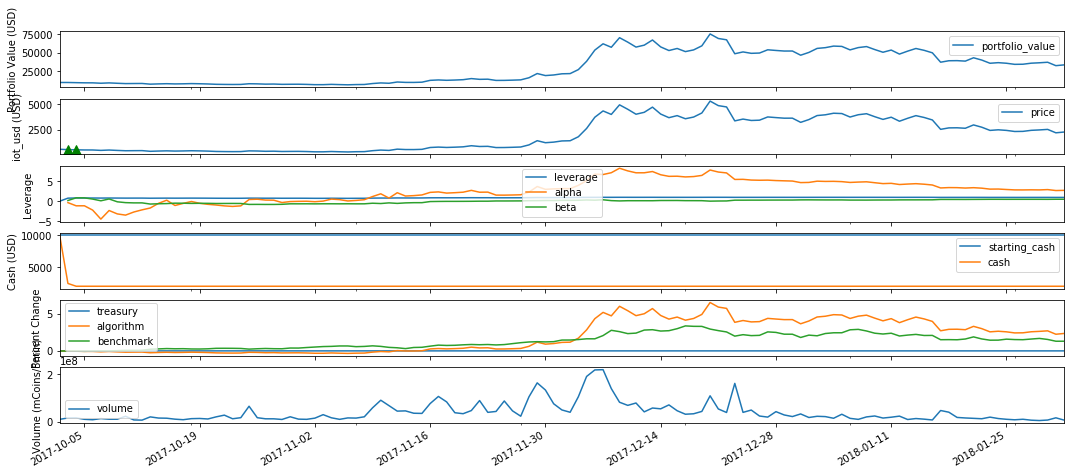

In [37]:
from catalyst import run_algorithm

result = run_algorithm(
        capital_base=10000,
        data_frequency='daily',
        initialize=initialize,
        handle_data=handle_data,
        analyze=analyze,
        exchange_name='bitfinex',
        algo_namespace='buy_and_hodl',
        base_currency='usd',
        start=pd.to_datetime('2017-10-01', utc=True),
        end=pd.to_datetime('2018-01-31', utc=True),
    )

In [38]:
result

,algo_volatility,algorithm_period_return,alpha,benchmark_period_return,benchmark_volatility,beta,capital_used,cash,ending_cash,ending_exposure,...,starting_cash,starting_exposure,starting_value,trading_days,transactions,treasury_period_return,volume,treasury,algorithm,benchmark
2017-10-01 23:59:00+00:00,NaN,0.000000,NaN,0.008518,NaN,NaN,0.00000,10000.00000,10000.00000,0.000000,...,10000,0.000000,0.000000,1,[],0.0233,9.745500e+06,0.0233,0.000000,0.008518
2017-10-02 23:59:00+00:00,0.017800,-0.001586,-0.360242,0.007579,0.106066,0.167820,-7566.35464,2433.64536,2433.64536,7550.497085,...,10000,0.000000,0.000000,2,"[{'amount': 13063.143972175503, 'dt': 2017-10-...",0.0234,1.546601e+07,0.0234,-0.001586,0.007579
2017-10-03 23:59:00+00:00,0.202618,-0.024407,-1.155401,-0.012938,0.233755,0.836660,-436.88680,1996.75856,1996.75856,7759.169684,...,10000,7550.497085,7550.497085,3,"[{'amount': 777.6867171122249, 'dt': 2017-10-0...",0.0233,1.596713e+07,0.0233,-0.024407,-0.012938
2017-10-04 23:59:00+00:00,0.201124,-0.046414,-1.147429,-0.034623,0.237042,0.828556,0.00000,1996.75856,1996.75856,7539.100338,...,10000,7759.169684,7759.169684,4,[],0.0233,9.856364e+06,0.0233,-0.046414,-0.034623
2017-10-05 23:59:00+00:00,0.184198,-0.049570,-2.219691,-0.012617,0.303463,0.524588,0.00000,1996.75856,1996.75856,7507.543382,...,10000,7539.100338,7539.100338,5,[],0.0235,7.995740e+06,0.0235,-0.049570,-0.012617
2017-10-06 23:59:00+00:00,0.339974,-0.102746,-4.469002,0.000664,0.290191,0.096396,0.00000,1996.75856,1996.75856,6975.778667,...,10000,7507.543382,7507.543382,6,[],0.0237,1.293838e+07,0.0237,-0.102746,0.000664
2017-10-07 23:59:00+00:00,0.514679,-0.057238,-2.328052,0.015685,0.279321,0.552790,0.00000,1996.75856,1996.75856,7430.865180,...,10000,6975.778667,6975.778667,7,[],0.0237,1.024958e+07,0.0237,-0.057238,0.015685
2017-10-08 23:59:00+00:00,0.542509,-0.108283,-3.176154,0.056056,0.333026,-0.157378,0.00000,1996.75856,1996.75856,6920.415345,...,10000,7430.865180,7430.865180,8,[],0.0237,1.034516e+07,0.0237,-0.108283,0.056056
2017-10-09 23:59:00+00:00,0.539140,-0.151189,-3.475998,0.095075,0.349430,-0.361113,0.00000,1996.75856,1996.75856,6491.349593,...,10000,6920.415345,6920.415345,9,[],0.0237,2.268425e+07,0.0237,-0.151189,0.095075
2017-10-10 23:59:00+00:00,0.528603,-0.141542,-2.703553,0.094021,0.334309,-0.424432,0.00000,1996.75856,1996.75856,6587.820183,...,10000,6491.349593,6491.349593,10,[],0.0235,7.145073e+06,0.0235,-0.141542,0.094021
